In [1]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import sys
sys.path.insert(0, 'functions/')
from tools import *
from h5_tools import *
from fitting_tools import *
from tools import *
import numpy as np
import h5py as h5
import matplotlib as mpl
from matplotlib import pyplot as plt
# import pandas as pd
import glob

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.7", "font.size": 14})
plt.rcParams['legend.title_fontsize'] = 'small'

In [3]:
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

# Select runs

In [4]:
# c1 temps 250-210 K full beam
runnames = ['ferritin_conc_gly_50_6']
datasetnumbers = [2,3,4,5,6]

if len(runnames) == 1:
    runnames = runnames*len(datasetnumbers)
runnames


['ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6']

In [5]:
T, Tr = [], []

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(float(info['Temperature, K']))
    
    else:
        print(filename, "\nFile exists: False")
T = np.array(T)

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0002.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0002
Temperature, K       250.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 250K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0003.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0003
Temperature, K       240.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 240K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0004.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0004
Temp

# Fig 1 - g2s

In [6]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
g2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
dg2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
delays = np.empty(shape=(len(datasetnumbers), len(delay)))

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[rep,:,:]
    dg2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[rep,:,:]
    delays[i,:] = load_data(filename, 'xpcs/g2s/delay')
    
print("Shape of the g2s (temp, qs, delay): ", np.shape(g2s))

Shape of the g2s (temp, qs, delay):  (5, 12, 80)


In [7]:
beta_vs_q = np.load('../03-source/contrast_vs_q.npy')

q=0.11 nm$^{-1}$ ferritin_conc_gly_50_6, Transm 100%


Text(0.02, 0.92, 'b')

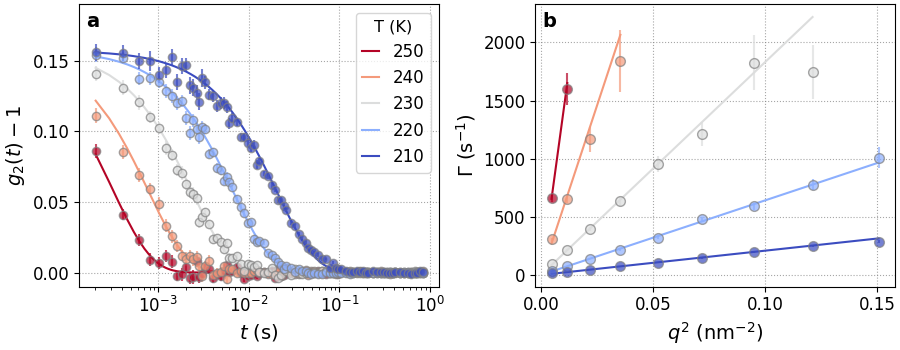

In [8]:
f, (a1,a3) = plt.subplots(1,2, figsize=(9,3.5), constrained_layout=True)

col = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))
qv_sel = 2
tol = 1e-3
qv_min, qv_max, qstep = 1, len(qv)-2, 1
Ds = np.empty(shape=(2, len(datasetnumbers)))

for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    
    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        
        if q==qv_sel:
            # a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7)
            a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[i], ls='', marker='o', ms=6, mec='gray', alpha=0.7)
            a1.plot(xc, curve, c=col[i], ls='-', alpha=1, label=f'{T[i]:.0f}')
    
    qs = qv[qv_min:qv_max:qstep]
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    cond = (taus>dtaus) & (dtaus!=0) & (taus>delays[0,1])

    popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])
    Ds[0,i], Ds[1,i] = popt[0]*1e-6, perr[0]*1e-6

    a3.plot(xc, curve, c=col[i], label=f'{Ds[0,i]:.2e}')
    # a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mfc='none')
    a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mec='gray', alpha=0.7, ms=7)

a1.legend(title=r'T (K)', fontsize=12, bbox_to_anchor=[1,1], handlelength=1, frameon=True)
print(f"q={qv[qv_sel]:.2f} nm$^{{-1}}$", f"{runname}, Transm {Tr[i]}%")
a1.set_xscale('log')
a1.set_xlabel(r'$t$ (s)')
a1.set_ylabel(r'$g_2(t)-1$')
a1.set_yticks(np.arange(0,0.16,0.05))
a1.set_ylim(-0.01,0.19)
a1.tick_params(axis='both', which='minor')#, bottom=False)
a1.tick_params(axis='both', which='major', labelsize=12)
a1.tick_params(axis='both', which='minor', labelsize=10)

a3.set_xlabel(r'$q^2$ (nm$^{-2}$)')
a3.set_ylabel(r'$\Gamma$ (s$^{-1}$)')
a3.set_xticks(np.arange(0,0.16,0.05))
a3.tick_params(axis='both', which='minor')#, bottom=False)
a3.tick_params(axis='both', which='major', labelsize=12)
a3.tick_params(axis='both', which='minor', labelsize=10)
a1.text(0.02, 0.92, 'a', fontweight='bold', transform=a1.transAxes)
a3.text(0.02, 0.92, 'b', fontweight='bold', transform=a3.transAxes)
# plt.savefig('../06-figs/g2s.png', dpi=300)

# Fig 2 - diffusion coefficient

### Arrhenius

In [9]:
# load dls data
DLS = load_npz_data('../03-source/DLS_diff_coeff.npz') # D in m^2/s, T in K
DLS['D'] = DLS['D']*1e12

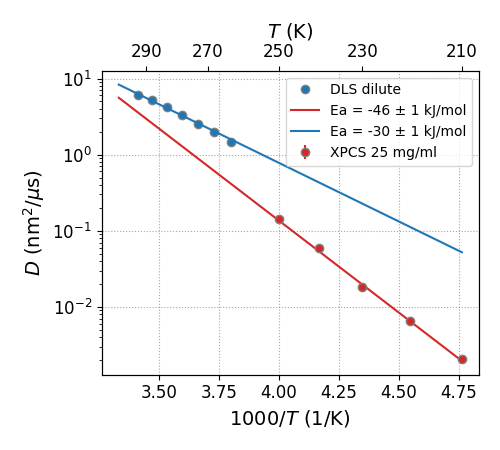

In [10]:
f, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)
ax2 = ax.twiny()
scale = 1e3

ax.errorbar(scale/T, Ds[0,:], Ds[1,:], ls='', marker='o', mec='gray', c='C3', label='XPCS 25 mg/ml')
ax.plot(scale/DLS['T'], DLS['D'], label='DLS dilute', c='C0', ls='', marker='o', mec='gray',)

# arrhenius fit
# xpcs
popt,xc,curve,perr = fit(arrhenius, T, Ds[0,:], sigma=Ds[1,:], p0=[15e4, -3e3])
Kbb = 1.3806e-23 # J/K
Na = 6.02214076e23 
Ea, dEa = popt[1] * Kbb / 1e3 * Na, perr[1] * Kbb / 1e3 * Na
new_T = np.linspace(210,300,100)
# ax.plot(scale/xc, curve, ls='-', c='C3',label=f'Ea = {Ea:.0f} ± {dEa:.0f} kJ/mol')
ax.plot(scale/new_T, arrhenius(new_T, *popt), ls='-', c='C3',label=f'Ea = {Ea:.0f} ± {dEa:.0f} kJ/mol')

# DLS
# a1.plot(scale/DLS['T'], 1*np.exp(-3.6e3/DLS['T']), ls='--', c='k')
popt2,xc2,curve2,perr2 = fit(arrhenius, DLS['T'],  DLS['D'], p0=[1e6, -3e3])
Kbb = 1.3806e-23 # J/K
Na = 6.02214076e23 
Ea2, dEa2 = popt2[1] * Kbb / 1e3 * Na, perr2[1] * Kbb / 1e3 * Na
# ax.plot(scale/xc2, curve2, ls='-', c='C0', label=f'Ea = {Ea2:.0f} ± {dEa2:.0f} kJ/mol')
ax.plot(scale/new_T, arrhenius(new_T, *popt2), ls='-', c='C0',label=f'Ea = {Ea2:.0f} ± {dEa2:.0f} kJ/mol')
# print(popt2)

# -- plot setting
ax.set_xlabel(f'${scale:.0f}/T$ (1/K)')
# ax.set_ylabel('Diffusion coefficient (nm$^{{2}}$/${{\mu}}$s)')
ax.set_ylabel('$D$ (nm$^{{2}}$/${{\mu}}$s)')
# ax.set_ylim([1e-15,1e-11])
ax.legend(fontsize=10)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.set_yticks(np.arange(1e-3,1.6e-1,0.05))

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(scale/np.arange(210,300,20))
ax2.set_xticklabels([f"{x:.0f}" for x in np.arange(210,300,20)])
ax2.set_xlabel('$T$ (K)', fontsize=14)
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)
# plt.savefig('../06-figs/diff_coeff_arr.png', dpi=300)

### Not Arrhenius

XPCS: Ea = 4.63e+01 ± 9.53e-01 kJ/mol
DLS: Ea = 2.95e+01 ± 7.30e-01 kJ/mol


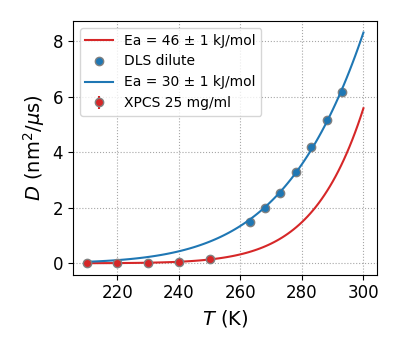

In [11]:
f, ax = plt.subplots(1,1, figsize=(4,3.5), tight_layout=True)

# arrhenius fit
# xpcs
ax.errorbar(T, Ds[0,:], Ds[1,:], ls='', marker='o', mec='gray', c='C3', label='XPCS 25 mg/ml')

popt,xc,curve,perr = fit(arrhenius, T, Ds[0,:], sigma=Ds[1,:], p0=[15e4, -3e3])
# ax.plot(xc, curve, ls='-', c='C3', label=f'Ea = {Ea:.0f} ± {dEa:.0f} kJ/mol')
Kbb = 1.3806e-23 # J/K
Na = 6.02214076e23 
Ea, dEa = -popt[1] * Kbb / 1e3 * Na, perr[1] * Kbb / 1e3 * Na
print(f"XPCS: Ea = {Ea:.2e} ± {dEa:.2e} kJ/mol")
new_T = np.linspace(210,300,100)
ax.plot(new_T, arrhenius(new_T, *popt), ls='-', c='C3',label=f'Ea = {Ea:.0f} ± {dEa:.0f} kJ/mol')

# DLS
ax.plot(DLS['T'], DLS['D'], label='DLS dilute', c='C0', ls='', marker='o', mec='gray',)
popt2,xc2,curve2,perr2 = fit(arrhenius, DLS['T'],  DLS['D'], p0=[1e6, -3e3])
Kbb = 1.3806e-23 # J/K
Na = 6.02214076e23 
Ea2, dEa2 = -popt2[1] * Kbb / 1e3 * Na, perr2[1] * Kbb / 1e3 * Na
# ax.plot(xc2, curve2, ls='-',  c='C0', label=f'Ea = {Ea2:.0f} ± {dEa2:.0f} kJ/mol')
ax.plot(new_T, arrhenius(new_T, *popt2), ls='-', c='C0',label=f'Ea = {Ea2:.0f} ± {dEa2:.0f} kJ/mol')
print(f"DLS: Ea = {Ea2:.2e} ± {dEa2:.2e} kJ/mol")


# -- plot setting
ax.set_xlabel(f'$T$ (K)')
ax.set_ylabel('$D$ (nm$^{{2}}$/${{\mu}}$s)')
# ax.set_ylim([1e-15,1e-11])
ax.legend(fontsize=10)
# ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.set_yticks(np.arange(1e-3,1.6e-1,0.05))
# plt.savefig('../06-figs/diff_coeff.png', dpi=300)

# Fig 3 - $\chi_4$

In [12]:
# select concentration
conc = 'c1'
qv = np.array([0.028, 0.068, 0.108, 0.148, 0.188, 0.228, 0.268, 0.308, 0.348, 0.388, 0.428, 0.468])

# load files and parameters
files = sorted(glob.glob(f"../03-source/chi4/chi4_{conc}*.npz"))
temps = np.unique([int(file[-14:-11]) for file in files])
inds = np.unique([int(file[-5:-4]) for file in files])

print(f"Temperatures available for {conc}: {temps}")


Temperatures available for c1: [210 220 230 240 250]


### q-dependence

Text(0.02, 0.9, 'b')

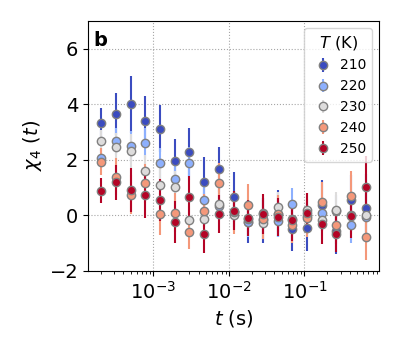

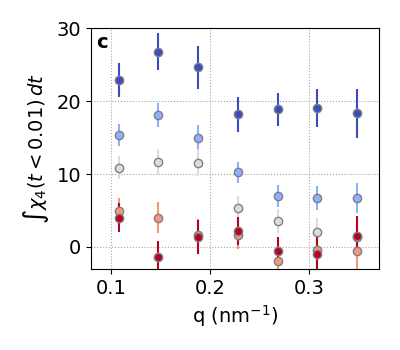

In [13]:
T_sel = temps[0]
q_int = 8
q_sel = 2

# f, (a1,a2) = plt.subplots(1,2,figsize=(11,4.5), tight_layout=True)
# f, a1 = plt.subplots(1,1,figsize=(4,3.5), tight_layout=True)
f3, a3 = plt.subplots(1,1,figsize=(4,3.5), tight_layout=True)
f2, a2 = plt.subplots(1,1,figsize=(4,3.5), tight_layout=True)

col = plt.cm.viridis(np.linspace(0,1,len(inds)))
col2 = plt.cm.coolwarm(np.linspace(0,1,len(temps)))

for j,T in enumerate(temps[:]):
    T_sel = temps[j]

    for i,ind in enumerate(inds):
        f = np.load(f"../03-source/chi4/chi4_{conc}_{T_sel}K_qind{ind}.npz")

        base = np.mean( f['chi4'][-10:])
        # if j == 0:
            # a1.errorbar(f['time'], f['chi4']-base, f['dchi4'], c=col[i], label=f'{qv[ind]:.2f}', ls='', marker='o', mec='gray')
        std_sum = np.sqrt(np.sum(f['dchi4'][:q_int]**2))
        # a2.errorbar(qv[ind], np.trapz(f['chi4'][:q_int]-base, f['time'][:q_int]), std_sum, ls='', c=col[i], marker='o', mec='gray')
        a2.errorbar(qv[ind], np.sum(f['chi4'][:q_int]-base), std_sum, ls='', c=col2[j], marker='o', mec='gray')
        
        if ind == q_sel:
            a3.errorbar(f['time'], f['chi4']-base, f['dchi4'], c=col2[j], label=f'{T:.0f}', ls='', marker='o', mec='gray')
    # a2.errorbar(qv[q_sel], np.sum(f['chi4'][:q_int]-base), std_sum, ls='', c=col2[j], marker='o', mec='gray')

# # a1.axvline(x=1e-2, ls='--', c='gray')
# a1.axvline(x=f['time'][q_int], ls='--', c='gray')

# a1.legend(title='q (nm$^{-1}$)', bbox_to_anchor=[1,1])
# a1.set_title(f'{conc}, T = {T_sel} K')
# a1.set_xscale('log')
# a1.set_xlabel('time (s)')
# a1.set_ylabel('$\chi_4$')

a2.set_xlim(0.08, 0.37)
a2.set_ylim(-3,30)
# a2.legend(temps[:-1], [])
a2.set_xlabel('q (nm$^{-1}$)')
a2.set_ylabel(f"$\int\chi_4(t<{f['time'][q_int]:.2f})\,dt$")
a2.text(0.02, 0.92, 'c', fontweight='bold', transform=a2.transAxes)

a3.set_xscale('log')
# a3.set_xlabel(f'$\tau (s)')
a3.legend(title='$T$ (K)', handletextpad=0.2, fontsize=10)
a3.set_xlabel(r"$t$ (s)")
a3.set_ylabel(r"$\chi_4$ ($t$)")
a3.set_ylim(-2,7)
a3.text(0.02, 0.9, 'b', fontweight='bold', transform=a3.transAxes)
# f3.savefig('../06-figs/chi4_time.png', dpi=300)
# f2.savefig('../06-figs/chi4_q.png', dpi=300)

### TTC

In [15]:
from Xana import Xana
import re
import tqdm

In [17]:
# c1
anadir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed'
datafolder = 'ferritin_conc_gly_50_6'
datasetnumber = 6 # [2,3,4,5,6] [250, 240, 230, 220, 210]

In [32]:
# ana_db_files = glob.glob(f'{anadir}/results/{datafolder}_{datasetnumber:04d}/p*/analysis_database.pkl')
# ana_db_files

In [33]:
def get_scan_number(s):
    s = str(s)
    s = re.search('(?<=scan)\d{4}', s)
    if s is not None:
        return int(s.group(0))
    else:
        return -1
    
def get_rep(x, reps_per_spot=1):
    scan = get_scan_number(x)
    rep = scan % reps_per_spot
    if rep == 0:
        rep = 4
    return rep

In [34]:
# d = Xana(fmtstr='ebs_id10_eiger500k', detector='eiger500k', setupfile=f'{anadir}/mask-setup/setup-fullmask-cryo-230417.pkl')

# for i, f in enumerate(ana_db_files):
#     if i == 0:
#         d.load_db(f)
#     else:
#         d.append_db(f)

In [35]:
# d.db['rep'] = d.db['master'].apply(lambda x: get_rep(x, reps_per_spot=4))
# d.db['scannumber'] = d.db['datdir'].apply(lambda x: get_scan_number(str(x)))

In [36]:
# rep = 1
# ind_xpcs = d.db[(d.db['analysis'] == 'xpcs')
#                 & (d.db['rep'] == rep)].index.values
# print(f"number of xpcs analysis: {len(ind_xpcs)}")
# d.db.loc[ind_xpcs]

In [23]:
# len(ind_xpcs)
# for key in d.get_item(ind_xpcs[0]).keys():
#     print(key, type(d.get_item(ind_xpcs[0])[key]), np.shape(d.get_item(ind_xpcs[0])[key]))

In [37]:
# ttc = list(d.get_item(ind_xpcs[0])['twotime_corf'].values())[2]
# time = d.get_item(ind_xpcs[0])['twotime_xy'][:]
# # ttcs = 0
# ttcs = np.empty(shape=(len(ind_xpcs), np.shape(ttc)[0], np.shape(ttc)[0]))

# for i,ind in enumerate(ind_xpcs[:]): #tqdm(enumerate(ind_xpcs[:10]), desc='index', leave=False, total=len(ind_xpcs)):
#     ttcs[i,:,:] = list(d.get_item(ind)['twotime_corf'].values())[2]
#     print(f'{i+1} / {len(ind_xpcs[:])}')
#     # ttcs += list(d.get_item(ind)['twotime_corf'].values())[2]

In [39]:
# ttcs_avg = np.mean(ttcs, axis=0)
ttcs_avg = np.load("../03-source/ttc-for-paper.npy")

In [40]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [41]:
# np.save("../03-source/ttc-for-paper", ttcs_avg)

/tmp/ipykernel_16577/1729092061.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=mpl.cm.turbo,  orientation='vertical', norm=mpl.colors.Normalize(vmin=vs[0],vmax=vs[1]), label='correlation', ticks=np.arange(vs[0],vs[1]+0.01,0.05))


Text(0.05, 0.92, 'a')

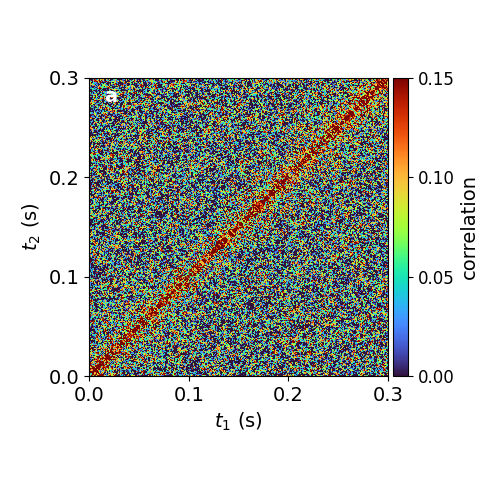

In [42]:
f, ax = plt.subplots(1,1, figsize=(5,5), tight_layout=True)
baseline = np.mean(ttcs_avg[:10,-10:])
norm = len(ind_xpcs)
vs = [0., .15]

ax.imshow(ttcs_avg - baseline, origin='lower', cmap='turbo', extent=(time[0], time[-1])*2, vmin=vs[0], vmax=vs[1], interpolation='gaussian')

ax.set_xlabel('$t_1$ (s)')
ax.set_ylabel('$t_2$ (s)')
t_lim = 0.3
ax.set_xlim(0,t_lim)
ax.set_ylim(0,t_lim)
ax.set_xticks(np.arange(0,0.31,0.1))
ax.set_yticks(np.arange(0,0.31,0.1))
divider = make_axes_locatable(ax)
cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=mpl.cm.turbo,  orientation='vertical', norm=mpl.colors.Normalize(vmin=vs[0],vmax=vs[1]), label='correlation', ticks=np.arange(vs[0],vs[1]+0.01,0.05))
cb1.ax.tick_params(labelsize=12)
ax.text(0.05, 0.92, 'a', transform=ax.transAxes, color='w',  fontweight='bold',)
# ax.tick_params(axis='both', which='minor', labelsize=10)


### All panels together

In [43]:
from matplotlib import gridspec
import scipy as sp
import scipy.interpolate

/tmp/ipykernel_16577/1802898013.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=mpl.cm.turbo,  orientation='vertical', norm=mpl.colors.Normalize(vmin=vs[0],vmax=vs[1]), label='correlation', ticks=np.arange(vs[0],vs[1]+0.01,0.05))


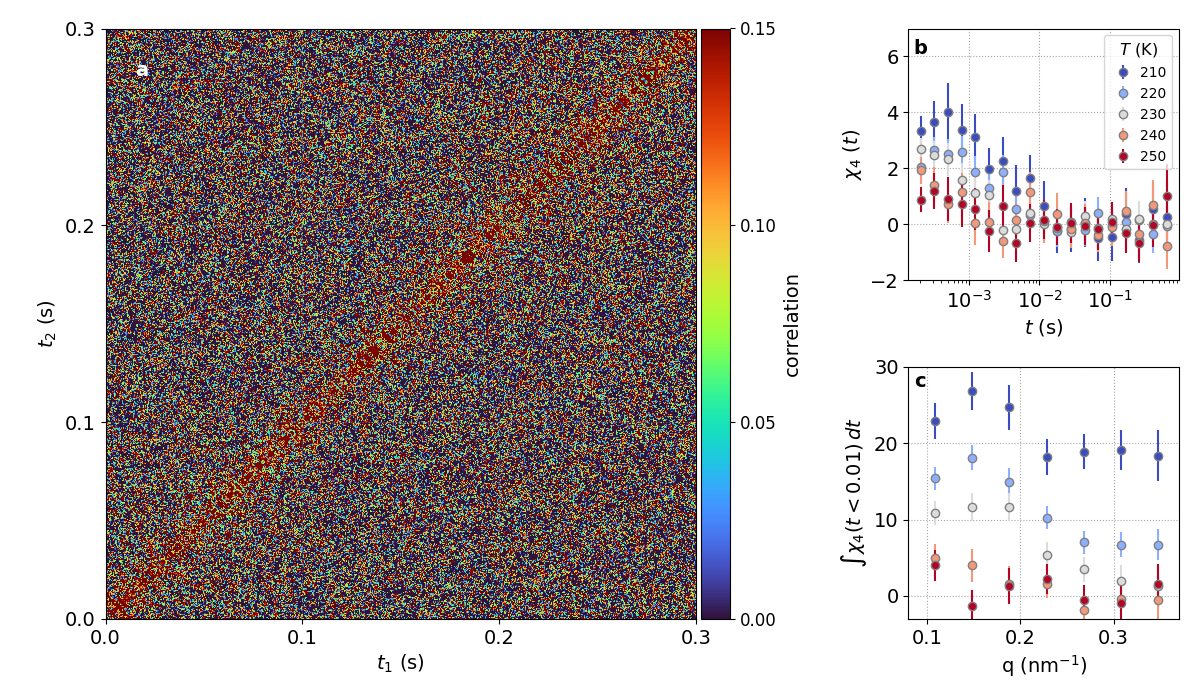

In [44]:
# creating grid for subplots
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(12)
 
ax1 = plt.subplot2grid(shape=(2, 3), loc=(0, 0), colspan=2, rowspan=2)
a3 = plt.subplot2grid(shape=(2, 3), loc=(0, 2), colspan=1)
a2 = plt.subplot2grid(shape=(2, 3), loc=(1, 2), rowspan=1) 
 
# -- PANEL A - TTC
baseline = np.mean(ttcs_avg[:10,-10:])
norm = len(ind_xpcs)
vs = [0., .15]
ax1.imshow(ttcs_avg - baseline, origin='lower', cmap='turbo', extent=(time[0], time[-1])*2, vmin=vs[0], vmax=vs[1], interpolation='bicubic')

ax1.set_xlabel('$t_1$ (s)')
ax1.set_ylabel('$t_2$ (s)')
t_lim = 0.3
ax1.set_xlim(0,t_lim)
ax1.set_ylim(0,t_lim)
ax1.set_xticks(np.arange(0,0.31,0.1))
ax1.set_yticks(np.arange(0,0.31,0.1))
divider = make_axes_locatable(ax1)
cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=mpl.cm.turbo,  orientation='vertical', norm=mpl.colors.Normalize(vmin=vs[0],vmax=vs[1]), label='correlation', ticks=np.arange(vs[0],vs[1]+0.01,0.05))
cb1.ax.tick_params(labelsize=12)
ax1.text(0.05, 0.92, 'a', transform=ax1.transAxes, color='w',  fontweight='bold',)


# PANEL B - CHI4 VS TIME
# PANEL C - CHI4 VS Q
T_sel = temps[0]
q_int = 8
q_sel = 2
col = plt.cm.coolwarm(np.linspace(0,1,len(temps)))

for j,T in enumerate(temps[:]):
    T_sel = temps[j]

    for i,ind in enumerate(inds):
        f = np.load(f"../03-source/chi4/chi4_{conc}_{T_sel}K_qind{ind}.npz")

        base = np.mean( f['chi4'][-10:])
        std_sum = np.sqrt(np.sum(f['dchi4'][:q_int]**2))
        a2.errorbar(qv[ind], np.sum(f['chi4'][:q_int]-base), std_sum, ls='', c=col[j], marker='o', mec='gray')
        
        if ind == q_sel:
            # y_interp =  sp.interpolate.interp1d(f['time'], f['chi4']-base, kind='quadratic')
            # new_t = np.linspace(np.min(f['time']), np.max(f['time']), 1000)
            # a3.plot(new_t, y_interp(new_t), c=col[j], ls='-',  alpha=0.7)
            a3.errorbar(f['time'], f['chi4']-base, f['dchi4'], c=col[j], label=f'{T:.0f}', ls='', marker='o', mec='gray')

a2.set_xlim(0.08, 0.37)
a2.set_ylim(-3,30)
a2.set_xlabel('q (nm$^{-1}$)')
a2.set_ylabel(f"$\int\chi_4(t<{f['time'][q_int]:.2f})\,dt$")
a2.text(0.02, 0.92, 'c', fontweight='bold', transform=a2.transAxes)

a3.set_xscale('log')
a3.legend(title='$T$ (K)', handletextpad=0.2, fontsize=10)
a3.set_xlabel(r"$t$ (s)")
a3.set_ylabel(r"$\chi_4$ ($t$)")
a3.set_ylim(-2,7)
a3.text(0.02, 0.9, 'b', fontweight='bold', transform=a3.transAxes)
fig.tight_layout()
 

In [55]:
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

    

In [62]:
factor = 2
ttc_rebinned = rebin(ttcs_avg - baseline, (ttcs_avg.shape[0]//factor, ttcs_avg.shape[0]//factor))
np.shape(ttc_rebinned)

(2495, 2495)

/tmp/ipykernel_16577/2871051451.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


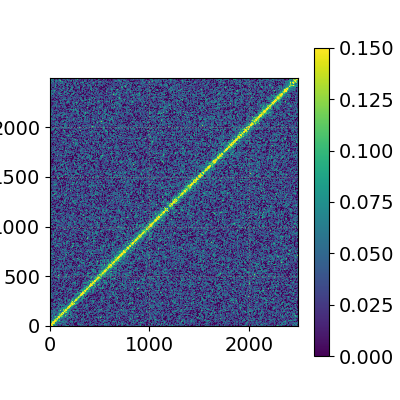

In [67]:
plt.figure(figsize=(4,4))
plt.imshow(ttc_rebinned, origin='lower', vmin=0, vmax=.15)
plt.colorbar()

/tmp/ipykernel_16577/812505965.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=mpl.cm.turbo,  orientation='vertical', norm=mpl.colors.Normalize(vmin=0,vmax=vs[1]), label='correlation', ticks=np.arange(0,vs[1]+0.01,0.05))
/tmp/ipykernel_16577/812505965.py:68: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=cmap,  orientation='vertical', norm=mpl.colors.BoundaryNorm(bounds, cmap.N), label='temperature (K)', ticks=np.arange(210,251,10))


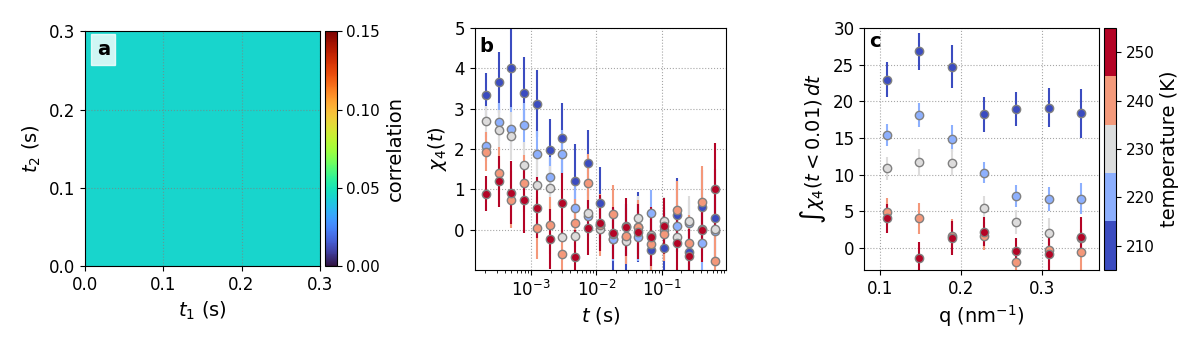

In [58]:
# creating grid for subplots
fig = plt.figure()
fig.set_figheight(3.5)
fig.set_figwidth(12)
 
ax1 = plt.subplot2grid(shape=(1, 3), loc=(0, 0), colspan=1, rowspan=1)
a3 = plt.subplot2grid(shape=(1, 3), loc=(0, 1), colspan=1)
a2 = plt.subplot2grid(shape=(1, 3), loc=(0, 2), rowspan=1) 
 
# -- PANEL A - TTC
baseline = np.mean(ttcs_avg[:10,-10:])
norm = len(ind_xpcs)
vs = [0.06, .15]
# ax1.imshow(ttcs_avg - baseline, origin='lower', cmap='turbo', extent=(time[0], time[-1])*2, vmin=vs[0], vmax=vs[1], interpolation='bicubic')
ax1.imshow(ttc_rebinned, origin='lower', cmap='turbo')#, vmin=vs[0], vmax=vs[1], interpolation='bicubic') # extent=(time[0], time[-1])*2,

ax1.set_xlabel('$t_1$ (s)')
ax1.set_ylabel('$t_2$ (s)')
t_lim = 0.2
ax1.set_xlim(0,t_lim)
ax1.set_ylim(0,t_lim)
ax1.set_xticks(np.arange(0,0.31,0.1))
ax1.set_yticks(np.arange(0,0.31,0.1))
divider = make_axes_locatable(ax1)
cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=mpl.cm.turbo,  orientation='vertical', norm=mpl.colors.Normalize(vmin=0,vmax=vs[1]), label='correlation', ticks=np.arange(0,vs[1]+0.01,0.05))
cb1.ax.tick_params(labelsize=11)
ax1.text(0.05, 0.9, 'a', transform=ax1.transAxes, color='k', fontweight='bold', bbox=dict(facecolor='w', edgecolor='w', alpha=0.8)) # fontweight='bold', fontsize=14,


# PANEL B - CHI4 VS TIME #### PANEL C - CHI4 VS Q
T_sel = temps[0]
q_int = 8
q_sel = 2
col = plt.cm.coolwarm(np.linspace(0,1,len(temps)))

for j,T in enumerate(temps[:]):
    T_sel = temps[j]

    for i,ind in enumerate(inds):
        f = np.load(f"../03-source/chi4/chi4_{conc}_{T_sel}K_qind{ind}.npz")

        base = np.mean( f['chi4'][-10:])
        std_sum = np.sqrt(np.sum(f['dchi4'][:q_int]**2))
        a2.errorbar(qv[ind], np.sum(f['chi4'][:q_int]-base), std_sum, ls='', c=col[j], marker='o', mec='gray')
        
        if ind == q_sel:
            a3.errorbar(f['time'], f['chi4']-base, f['dchi4'], c=col[j], label=f'{T:.0f}', ls='', marker='o', mec='gray')

a2.set_xlim(0.08, 0.37)
a2.set_ylim(-3,30)
a2.set_xlabel('q (nm$^{-1}$)')
# a2.set_ylabel(f"$\int\chi_4(tau <{f['time'][q_int]:.2f})\,dt$")
a2.set_ylabel(r"$\int\chi_4(t <0.01)\,dt$")
a2.text(0.02, 0.92, 'c', fontweight='bold', transform=a2.transAxes)

a3.set_xscale('log')
# a3.legend(title='$T$ (K)', handletextpad=0.2, fontsize=10)
a3.set_xlabel(r"$t$ (s)")
a3.set_ylabel(r"$\chi_4 (t)$")
a3.set_ylim(-1,5)
a3.set_yticks(np.arange(0,5.1,1))
a3.text(0.02, 0.9, 'b', fontweight='bold', transform=a3.transAxes)

# colorbar
bounds = [205, 215, 225, 235, 245, 255]
divider = make_axes_locatable(a2)
cmap = mpl.cm.coolwarm
cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=cmap,  orientation='vertical', norm=mpl.colors.BoundaryNorm(bounds, cmap.N), label='temperature (K)', ticks=np.arange(210,251,10))
cb1.ax.tick_params(labelsize=11)
# cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=cmap,  orientation='vertical', norm=mpl.colors.BoundaryNorm(bounds, cmap.N), label='temperature (K)', ticks=np.arange(210,251,10))
# cb1.ax.tick_params(labelsize=11)

ax1.tick_params(axis='both', which='major', labelsize=12)
a2.tick_params(axis='both', which='major', labelsize=12)
a3.tick_params(axis='both', which='major', labelsize=12)

fig.tight_layout()
# fig.savefig('../06-figs/chi4_tttc.png', dpi=200)
 

250